In [1]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../images/metadata/train_metadata.csv')
val = pd.read_csv('../images/metadata/val_metadata.csv')
valb = pd.read_csv('../images/metadata/valb_metadata.csv')

In [3]:
train['Image_File'] = train.iloc[:, 2].str.lstrip('/kaggle/input/isic-2019jpgresized224x224imagechallenge')
val['Image_File'] = val.iloc[:, 2].str.lstrip('/kaggle/input/isic-2019jpgresized224x224imagechallenge')
valb['Image_File'] = valb.iloc[:, 2].str.lstrip('/kaggle/input/isic-2019jpgresized224x224imagechallenge')


In [6]:
train.to_csv('../image/metadata/train_metadata_updated.csv', index=False)
val.to_csv('../images/metadata/val_metadata_updated.csv', index=False)
valb.to_csv('../images/metadata/valb_metadata_updated.csv', index=False)

In [4]:
train_df = pd.read_csv('../images/metadata/train_metadata_updated.csv')
val_df = pd.read_csv('../images/metadata/val_metadata_updated.csv')

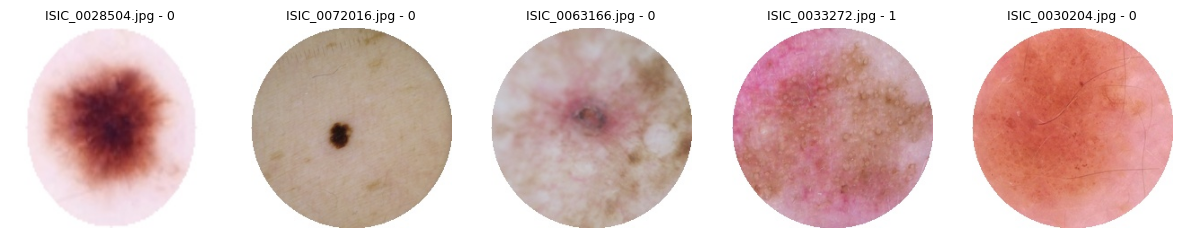

In [6]:
# let's check to see how these images are stored
import os
from pathlib import Path
import random

import cv2
from matplotlib import pyplot as plt

def load_images_from_directory(directory, num_images=5):
    """
    Load a specified number of random images from a directory.
    """
    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    selected_files = random.sample(image_files, num_images)
    images = []
    
    for file_name in selected_files:
        file_path = os.path.join(directory, file_name)
        image = cv2.imread(file_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display
        images.append((file_name, image_rgb))
    
    return images

def display_images(df, images):
    """
    Display a list of images with their filenames using matplotlib.
    """
    num_images = len(images)
    plt.figure(figsize=(15, 10))
    
    for i, (file_name, image) in enumerate(images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        
        isic_id = file_name.split('.')[0]
        label = df[df['isic_id'] == isic_id]['Label'].values[0]
        plt.title(Path(file_name).name + " - " + str(label), fontsize=9)
        plt.axis('off')
    
    plt.show()

directory = '../images/train_images'
images = load_images_from_directory(directory, num_images=5)
display_images(train_df, images)

## Model with CUDA

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SoftAttention(nn.Module):
    def __init__(self, in_channels, multiheads, concat_with_x=False, aggregate=False):
        super(SoftAttention, self).__init__()
        self.channels = in_channels
        self.multiheads = multiheads
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x
        
        # Replace Conv3D with equivalent operations in PyTorch
        self.conv = nn.Conv2d(in_channels, multiheads, kernel_size=3, padding=1)
        
    def forward(self, x):
        # Get attention weights
        attention = self.conv(x)  # [batch, multiheads, height, width]
        attention = F.relu(attention)
        
        # Reshape attention to [batch, multiheads, height*width]
        batch, _, height, width = attention.size()
        attention = attention.view(batch, self.multiheads, -1)
        
        # Apply softmax
        attention = F.softmax(attention, dim=-1)
        attention = attention.view(batch, self.multiheads, height, width)
        
        if not self.aggregate_channels:
            # Expand attention for broadcasting
            attention = attention.unsqueeze(2)  # [batch, multiheads, 1, height, width]
            x = x.unsqueeze(1)  # [batch, 1, channels, height, width]
            
            # Apply attention
            output = x * attention  # Broadcasting will handle the rest
            output = output.view(batch, -1, height, width)
            
        else:
            # Sum attention weights across heads
            attention = attention.sum(dim=1, keepdim=True)  # [batch, 1, height, width]
            output = x * attention
        
        if self.concat_input_with_scaled:
            output = torch.cat([output, x], dim=1)
            
        return output, attention.squeeze(1)  # Return output and attention maps


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm

# Check for CUDA availability and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Custom dataset class
class ImageDataset(Dataset):
    def __init__(self, dataframe, directory, transform=None):
        self.dataframe = dataframe
        self.directory = directory
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 2]
        img_path = os.path.join(self.directory, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx, 3]
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = ImageDataset(dataframe=train_df, directory=directory, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)  # Added pin_memory=True for faster data transfer to GPU

# Define the model with attention
class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        attention_weights = self.attention(x)
        return x * attention_weights

class VGG16WithAttention(nn.Module):
    def __init__(self):
        super(VGG16WithAttention, self).__init__()
        # Load pretrained VGG16
        vgg16 = models.vgg16(pretrained=True)
        
        # Split VGG16 into sections
        self.features_1 = nn.Sequential(*list(vgg16.features.children())[:24])
        self.attention = SoftAttention(in_channels=512, multiheads=1, aggregate=True)  # Using SoftAttention instead
        self.features_2 = nn.Sequential(*list(vgg16.features.children())[24:])
        self.avgpool = vgg16.avgpool
        
        # Modify classifier for binary classification
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1)
        )
    
    def forward(self, x):
        x = self.features_1(x)
        x, attention_weights = self.attention(x)  # SoftAttention returns both output and attention weights
        x = self.features_2(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return torch.sigmoid(x)

# Initialize model and move it to GPU
model = VGG16WithAttention().to(device)

Using device: cpu


In [9]:
def print_model_structure(model):
    print("Model Architecture:")
    print("-" * 50)
    
    print("Features 1 (Initial Convolution Layers):")
    for i, layer in enumerate(model.features_1):
        print(f"  {i}: {layer}")
    
    print("\nAttention Block:")
    print(f"  {model.attention}")
    
    print("\nFeatures 2 (Final Convolution Layers):")
    for i, layer in enumerate(model.features_2):
        print(f"  {i}: {layer}")
    
    print("\nAverage Pooling:")
    print(f"  {model.avgpool}")
    
    print("\nClassifier:")
    for i, layer in enumerate(model.classifier):
        print(f"  {i}: {layer}")

print_model_structure(model)

Model Architecture:
--------------------------------------------------
Features 1 (Initial Convolution Layers):
  0: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  1: ReLU(inplace=True)
  2: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  3: ReLU(inplace=True)
  4: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  5: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  6: ReLU(inplace=True)
  7: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  8: ReLU(inplace=True)
  9: MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  10: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  11: ReLU(inplace=True)
  12: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  13: ReLU(inplace=True)
  14: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  15: ReLU(inplace=True)
  16: MaxPool2d(kernel_size=2, stride=2, padding=

In [14]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        # Move input data to GPU
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete")

# Optional: move model back to CPU if needed for inference
model = model.cpu()

# Create results directory if it doesn't exist
os.makedirs('../results', exist_ok=True)

# Save model weights
torch.save(model.state_dict(), '../results/vgg16_attention_weights.pth')
print("Model weights saved successfully")

Epoch 1/1:   0%|          | 1/240 [00:34<2:18:57, 34.88s/it]


KeyboardInterrupt: 

In [10]:
valb_df = pd.read_csv(r'../images/metadata/valb_metadata_updated.csv')

Evaluating: 100%|██████████| 37/37 [02:50<00:00,  4.60s/it]


Model Performance Metrics on Validation Set:
Accuracy: 0.5000
Precision: 0.5000
Recall: 1.0000
F1 Score: 0.6667
AUC-ROC: 0.5000


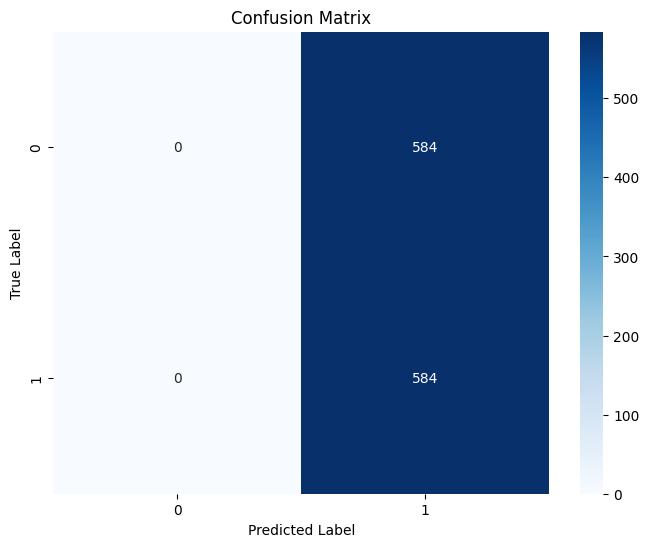

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

# Create validation dataset and dataloader
val_directory = '../images/valb_images'
val_dataset = ImageDataset(dataframe=valb_df, directory=val_directory, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    predictions = []
    actual = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            outputs = model(images)
            predicted = (outputs >= 0.5).float()
            predictions.extend(predicted.cpu().numpy())
            actual.extend(labels.cpu().numpy())
    
    return predictions, actual

# Calculate metrics

# Load model weights
model = VGG16WithAttention()
checkpoint = torch.load('../results/vgg16_attention_final.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Get predictions
predictions, actual = evaluate_model(model, val_loader)

# Calculate metrics
accuracy = accuracy_score(actual, predictions)
precision = precision_score(actual, predictions)
recall = recall_score(actual, predictions)
f1 = f1_score(actual, predictions)
auc = roc_auc_score(actual, predictions)

# Print results
print("\nModel Performance Metrics on Validation Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

# Generate and plot confusion matrix

cm = confusion_matrix(actual, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()